# Hopfield Neural Network

Implementation

Hopfield networks serve as associative memory systems with binary threshold nodes. Hopfield networks also provide a model for understanding human memory.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc as sp
import matplotlib.image as img

import seaborn as sns
sns.set_palette('hls', 10)
from tqdm import tqdm

ModuleNotFoundError: No module named 'tqdm'

In [8]:
def trainer(vector):
    vector = vector.flatten()
    coefMat = np.zeros([len(vector), len(vector)])
    for i in range(len(vector)):
        for j in range(len(vector)):
            if (i!=(i-j)):
                coefMat[i][i-j] = vector[i]*vector[i-j]
    vector = np.reshape(vector, [int(np.sqrt(len(vector))), int(np.sqrt(len(vector)))])
    return coefMat

def prediction(curuptedVec, coefMat):
    curuptedVec = curuptedVec.flatten()
    predictVec = np.zeros(len(curuptedVec))
    
    for i in range(len(curuptedVec)):
        temp = 0
        for j in range(len(curuptedVec)):
            temp += coefMat[i][j] * curuptedVec[j]
        if (temp > 0):
            predictVec[i] = 1
        if (temp < 0):
            predictVec[i] = -1
    
    predictVec = np.reshape(predictVec, [int(np.sqrt(len(predictVec))), int(np.sqrt(len(predictVec)))])
    return predictVec

def imageGenerator(imageVector):
    cleanImage = np.zeros([len(imageVector), len(imageVector)])
    for i in range(len(imageVector)):
        for j in range(len(imageVector)):
            if (imageVector[i][j] == 255):
                cleanImage[i][j] = 1
            else:
                cleanImage[i][j] = -1
    
    noisyImage = cleanImage + np.random.normal(0, 2, [len(image), len(image)])
    
    for i in range(len(image)):
        for j in range(len(image)):
            if (noisyImage[i][j] >= 0):
                noisyImage[i][j] = 1
            else:
                noisyImage[i][j] = -1
    
    return cleanImage, noisyImage

In [9]:
image = img.imread("bird.png", "w").copy()
vector, noisyVec = imageGenerator(image)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Sun Jul 29 08:40:49 2018

@author: user
"""

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

class HopfieldNetwork(object):      
    def train_weights(self, train_data):
        print("Start to train weights...")
        num_data =  len(train_data)
        self.num_neuron = train_data[0].shape[0]
        
        # initialize weights
        W = np.zeros((self.num_neuron, self.num_neuron))
        rho = np.sum([np.sum(t) for t in train_data]) / (num_data*self.num_neuron)
        
        # Hebb rule
        for i in tqdm(range(num_data)):
            t = train_data[i] - rho
            W += np.outer(t, t)
        
        # Make diagonal element of W into 0
        diagW = np.diag(np.diag(W))
        W = W - diagW
        W /= num_data
        
        self.W = W 
    
    def predict(self, data, num_iter=20, threshold=0, asyn=False):
        print("Start to predict...")
        self.num_iter = num_iter
        self.threshold = threshold
        self.asyn = asyn
        
        # Copy to avoid call by reference 
        copied_data = np.copy(data)
        
        # Define predict list
        predicted = []
        for i in tqdm(range(len(data))):
            predicted.append(self._run(copied_data[i]))
        return predicted
    
    def _run(self, init_s):
        if self.asyn==False:
            """
            Synchronous update
            """
            # Compute initial state energy
            s = init_s

            e = self.energy(s)
            
            # Iteration
            for i in range(self.num_iter):
                # Update s
                s = np.sign(self.W @ s - self.threshold)
                # Compute new state energy
                e_new = self.energy(s)
                
                # s is converged
                if e == e_new:
                    return s
                # Update energy
                e = e_new
            return s
        else:
            """
            Asynchronous update
            """
            # Compute initial state energy
            s = init_s
            e = self.energy(s)
            
            # Iteration
            for i in range(self.num_iter):
                for j in range(100):
                    # Select random neuron
                    idx = np.random.randint(0, self.num_neuron) 
                    # Update s
                    s[idx] = np.sign(self.W[idx].T @ s - self.threshold)
                
                # Compute new state energy
                e_new = self.energy(s)
                
                # s is converged
                if e == e_new:
                    return s
                # Update energy
                e = e_new
            return s
    
    
    def energy(self, s):
        return -0.5 * s @ self.W @ s + np.sum(s * self.threshold)

    def plot_weights(self):
        plt.figure(figsize=(6, 5))
        w_mat = plt.imshow(self.W, cmap=cm.coolwarm)
        plt.colorbar(w_mat)
        plt.title("Network Weights")
        plt.tight_layout()
        plt.savefig("weights.png")
        plt.show()

In [9]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [10]:
%pip install scikit-image

Start to data preprocessing...
Start to train weights...


100%|██████████| 4/4 [00:02<00:00,  1.35it/s]


Start to predict...


100%|██████████| 4/4 [00:01<00:00,  2.02it/s]


Show prediction results...


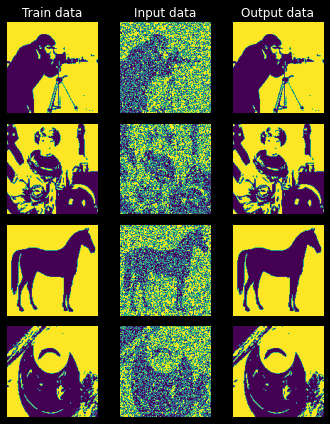

Show network weights matrix...


In [11]:
# -*- coding: utf-8 -*-
"""
Created on Sun Jul 29 08:40:49 2018

@author: user
"""

import numpy as np
np.random.seed(1)
import matplotlib.pyplot as plt
import skimage.data
from skimage.color import rgb2gray
from skimage.filters import threshold_mean
from skimage.transform import resize

# Utils
def get_corrupted_input(input, corruption_level):
    corrupted = np.copy(input)
    inv = np.random.binomial(n=1, p=corruption_level, size=len(input))
    for i, v in enumerate(input):
        if inv[i]:
            corrupted[i] = -1 * v
    return corrupted

def reshape(data):
    dim = int(np.sqrt(len(data)))
    data = np.reshape(data, (dim, dim))
    return data

def plot(data, test, predicted, figsize=(5, 6)):
    data = [reshape(d) for d in data]
    test = [reshape(d) for d in test]
    predicted = [reshape(d) for d in predicted]

    fig, axarr = plt.subplots(len(data), 3, figsize=figsize)
    for i in range(len(data)):
        if i==0:
            axarr[i, 0].set_title('Train data')
            axarr[i, 1].set_title("Input data")
            axarr[i, 2].set_title('Output data')

        axarr[i, 0].imshow(data[i])
        axarr[i, 0].axis('off')
        axarr[i, 1].imshow(test[i])
        axarr[i, 1].axis('off')
        axarr[i, 2].imshow(predicted[i])
        axarr[i, 2].axis('off')

    plt.tight_layout()
    plt.savefig("result.png")
    plt.show()

def preprocessing(img, w=128, h=128):
    # Resize image
    img = resize(img, (w,h), mode='reflect')

    # Thresholding
    thresh = threshold_mean(img)
    binary = img > thresh
    shift = 2*(binary*1)-1 # Boolian to int

    # Reshape
    flatten = np.reshape(shift, (w*h))
    return flatten

def main():
    # Load data
    camera = skimage.data.camera()
    astronaut = rgb2gray(skimage.data.astronaut())
    horse = skimage.data.horse()
    coffee = rgb2gray(skimage.data.coffee())

    # Marge data
    data = [camera, astronaut, horse, coffee]

    # Preprocessing
    print("Start to data preprocessing...")
    data = [preprocessing(d) for d in data]

    # Create Hopfield Network Model
    model = HopfieldNetwork()
    model.train_weights(data)

    # Generate testset
    test = [get_corrupted_input(d, 0.3) for d in data]

    predicted = model.predict(test, threshold=0, asyn=False)
    print("Show prediction results...")
    plot(data, test, predicted)
    print("Show network weights matrix...")
    #model.plot_weights()

if __name__ == '__main__':
    main()

11501568/11490434 [==============================] - 3s 0us/step
Start to data preprocessing...
Start to train weights...


100%|██████████| 3/3 [00:00<00:00, 428.41it/s]


Start to predict...


100%|██████████| 3/3 [00:00<00:00, 54.29it/s]

Show prediction results...


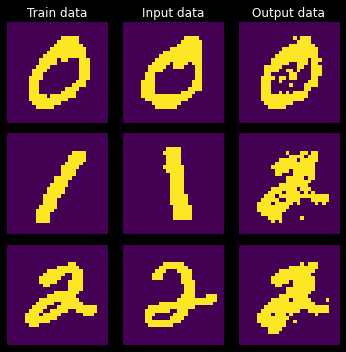

Show network weights matrix...


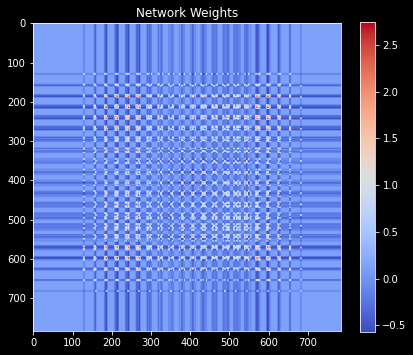

In [12]:
# -*- coding: utf-8 -*-
"""
Created on Sun Jul 29 08:40:49 2018

@author: user
"""

import numpy as np
from matplotlib import pyplot as plt
from skimage.filters import threshold_mean
from keras.datasets import mnist

# Utils
def reshape(data):
    dim = int(np.sqrt(len(data)))
    data = np.reshape(data, (dim, dim))
    return data

def plot(data, test, predicted, figsize=(3, 3)):
    data = [reshape(d) for d in data]
    test = [reshape(d) for d in test]
    predicted = [reshape(d) for d in predicted]
    
    fig, axarr = plt.subplots(len(data), 3, figsize=figsize)
    for i in range(len(data)):
        if i==0:
            axarr[i, 0].set_title('Train data')
            axarr[i, 1].set_title("Input data")
            axarr[i, 2].set_title('Output data')
            
        axarr[i, 0].imshow(data[i])
        axarr[i, 0].axis('off')
        axarr[i, 1].imshow(test[i])
        axarr[i, 1].axis('off')
        axarr[i, 2].imshow(predicted[i])
        axarr[i, 2].axis('off')
            
    plt.tight_layout()
    plt.savefig("result_mnist.png")
    plt.show()

def preprocessing(img):
    w, h = img.shape
    # Thresholding
    thresh = threshold_mean(img)
    binary = img > thresh
    shift = 2*(binary*1)-1 # Boolian to int
    
    # Reshape
    flatten = np.reshape(shift, (w*h))
    return flatten

def main():
    # Load data
    (x_train, y_train), (_, _ )= mnist.load_data()
    data = []
    for i in range(3):
        xi = x_train[y_train==i]
        data.append(xi[0])
    
    # Preprocessing
    print("Start to data preprocessing...")
    data = [preprocessing(d) for d in data]
    
    # Create Hopfield Network Model
    model = HopfieldNetwork()
    model.train_weights(data)
    
    # Make test datalist
    test = []
    for i in range(3):
        xi = x_train[y_train==i]
        test.append(xi[1])
    test = [preprocessing(d) for d in test]
    
    predicted = model.predict(test, threshold=50, asyn=True)
    print("Show prediction results...")
    plot(data, test, predicted, figsize=(5, 5))
    print("Show network weights matrix...")
    model.plot_weights()
    
if __name__ == '__main__':
    main()